# Bit Loading - M-QAM / M-PSK - OFDM Systems

- Given Values:
    - Total Power: \( P \)
    - Number of Subcarriers: \( N \)
    - Global Signal-to-Noise Ratio: \( SNR \)
    - Desired Symbol Error Rate: \( SER \)
    - Bandwidth: \( BW \)


In [552]:
from typing import Type
from ofdm_based_systems.configuration.enums import ConstellationType
from ofdm_based_systems.constellation.models import IConstellationMapper, PSKConstellationMapper, QAMConstellationMapper
from pydantic import BaseModel

NUMBER_OF_SYMBOLS =     10000
TOTAL_POWER_WATTS =     1.0
NUMBER_OF_SUBCARRIERS = 64
GLOBAL_SNR_dB =         20.0
DESIRED_SER =           1e-3
BANDWIDTH_HZ =          1
CONSTELLATION_TYPE = ConstellationType.QAM

CONSTELLATION_TYPE_MAP = {
    ConstellationType.QAM: QAMConstellationMapper,
    ConstellationType.PSK: PSKConstellationMapper,
    # Add other mappings as needed
}

class Parameters(BaseModel):
    number_of_symbols: int          # Number of Symbols
    total_power_watts: float              # Total Power (Watts)
    number_of_subcarriers: int      # Number of Subcarriers
    snr_dB: float                   # Global Signal-to-Noise Ratio in dB
    ser_target: float               # Desired Symbol Error Rate
    bandwidth_hz: float             # Bandwidth (Hz)
    constellation_type: Type[IConstellationMapper]  # Constellation Type

    @property
    def total_power_milliwatts(self) -> float:
        return self.total_power_watts * 1e3

params = Parameters(
    number_of_symbols=NUMBER_OF_SYMBOLS,
    total_power_watts=TOTAL_POWER_WATTS,
    number_of_subcarriers=NUMBER_OF_SUBCARRIERS,
    snr_dB=GLOBAL_SNR_dB,
    ser_target=DESIRED_SER,
    bandwidth_hz=BANDWIDTH_HZ,
    constellation_type=CONSTELLATION_TYPE_MAP[CONSTELLATION_TYPE],
)

print(params)

number_of_symbols=10000 total_power_watts=1.0 number_of_subcarriers=64 snr_dB=20.0 ser_target=0.001 bandwidth_hz=1.0 constellation_type=<class 'ofdm_based_systems.constellation.models.QAMConstellationMapper'>


In [553]:
from typing import BinaryIO, Dict, List


YELLOW_CMD = "\033[93m"
RED_CMD = "\033[91m"
RESET_CMD = "\033[0m"

WARNING_EMOJI = "🚨"
ERROR_EMOJI = "❌"

total_excetpions: Dict[str, int] = {
    "warnings": 0,
    "errors": 0
}

def print_warning_message(message: str) -> None:
    print(f"{WARNING_EMOJI} {YELLOW_CMD}Warning:{RESET_CMD} {message}")
    total_excetpions["warnings"] += 1

def print_error_message(message: str) -> None:
    print(f"{ERROR_EMOJI} {RED_CMD}Error:{RESET_CMD} {message}")
    total_excetpions["errors"] += 1

def read_bits_from_stream(stream: BinaryIO) -> List[int]:
    """Reads bits from a binary stream and returns them as a list of integers (0s and 1s)."""
    byte = stream.read(1)
    _bits = []
    while byte:
        byte_value = ord(byte)
        for i in range(8):
            _bits.append((byte_value >> (7 - i)) & 1)
        byte = stream.read(1)
    stream.seek(0)  # Reset stream position to the beginning
    return _bits

In [554]:
from typing import List, Optional
import numpy as np
import matplotlib.pyplot as plt

"""
Define, here, functions to plot many data formats
"""

def plot_vectors_as_bar_chart(
        vectors: List[np.ndarray],
        titles: List[str],
        xlabels: List[str],
        ylabels: List[str],
        colors: Optional[List[str]] = None
    ) -> None:
    """Plot multiple vectors as bar charts in a single figure."""
    amount_of_plots = len(vectors)
    if len(titles) != amount_of_plots:
        raise ValueError("Titles length must match amount of vectors.")
    if len(xlabels) != amount_of_plots:
        raise ValueError("X-labels length must match amount of vectors.")
    if len(ylabels) != amount_of_plots:
        raise ValueError("Y-labels length must match amount of vectors.")

    if colors is None:
        colors = ['blue'] * len(vectors)

    if len(colors) != amount_of_plots:
        colors.extend(['blue'] * (amount_of_plots - len(colors)))

    fig, axes = plt.subplots(1, amount_of_plots, figsize=(5 * amount_of_plots, 4))
    if amount_of_plots == 1:
        axes = [axes]  # Make it iterable
    for i, ax in enumerate(axes):
        ax.bar(range(len(vectors[i])), vectors[i], color=colors[i])
        ax.set_title(titles[i])
        ax.set_xlabel(xlabels[i])
        ax.set_ylabel(ylabels[i])
    plt.tight_layout()
    plt.show()

In [555]:
from typing import Any, Dict

# Initiate simulation results dictionary

simulation_results: Dict[str, Any] = {}

In [556]:
def calculate_snr_linear(params: Parameters) -> float:
    snr_db = params.snr_dB
    snr_linear = 10 ** (snr_db / 10)
    return snr_linear

def calculate_noise_power(params: Parameters, snr_linear: float) -> float:
    total_power_watts = params.total_power_watts
    noise_power_watts = total_power_watts / snr_linear
    return noise_power_watts


In [557]:
simulation_results["snr_linear"] = calculate_snr_linear(params)
simulation_results["noise_power_watts"] = calculate_noise_power(params, simulation_results["snr_linear"])

print(simulation_results)

{'snr_linear': 100.0, 'noise_power_watts': 0.01}


channel_impulse_response shape = (1,)


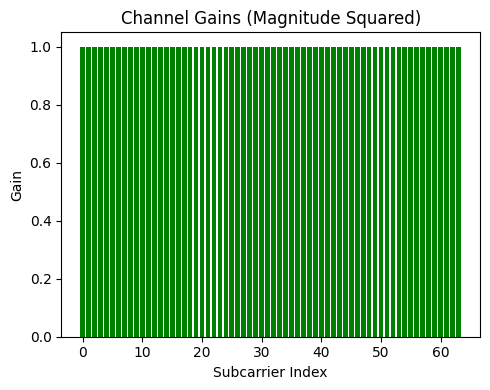

In [558]:
import numpy as np
from ofdm_based_systems.channel.models import ChannelModel


impulse_response = np.array([1.0]) # Example: Flat channel
#impulse_response = np.load("../config/channel_models/Lin-Phoong_P2.npy")

channel: ChannelModel = ChannelModel(
    impulse_response=impulse_response,
    snr_db=params.snr_dB
)

simulation_results["channel_impulse_response"] = channel.impulse_response
simulation_results["channel_frequency_response"] = channel.get_frequency_response(
    n_fft=params.number_of_subcarriers
)
simulation_results["channel_gains"] = channel.get_gains(
    n_fft=params.number_of_subcarriers
)
print(f"channel_impulse_response shape = {simulation_results["channel_impulse_response"].shape}")

plot_vectors_as_bar_chart(
    vectors=[
        simulation_results["channel_gains"],
    ],
    titles=[
        "Channel Gains (Magnitude Squared)",
    ],
    xlabels=[
        "Subcarrier Index",
    ],
    ylabels=[
        "Gain",
    ],
    colors=[
        "green",
    ]
)

Total Power Allocated: 1.0 Watts


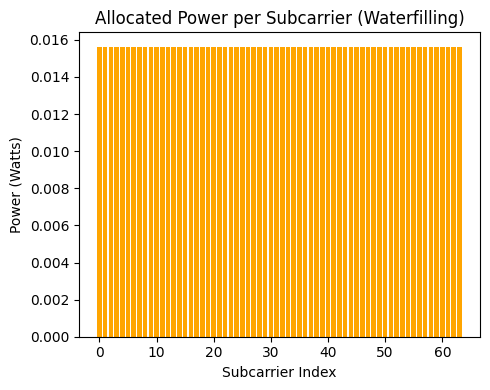

In [559]:
from ofdm_based_systems.power_allocation.models import WaterfillingPowerAllocation


waterfilling_power_allocator: WaterfillingPowerAllocation = WaterfillingPowerAllocation(
    total_power=params.total_power_watts,
    channel_gains=simulation_results["channel_gains"],
    noise_power=simulation_results["noise_power_watts"]
)

allocated_powers = waterfilling_power_allocator.allocate()
simulation_results["allocated_powers"] = allocated_powers

total_power_allocated = np.sum(allocated_powers)
print(f"Total Power Allocated: {total_power_allocated} Watts")
if not np.isclose(total_power_allocated, params.total_power_watts):
    print_warning_message(
        f"Total power allocated ({total_power_allocated} Watts) does not match total power available ({params.total_power_watts} Watts)."
    )

plot_vectors_as_bar_chart(
    vectors=[
        simulation_results["allocated_powers"],
    ],
    titles=[
        "Allocated Power per Subcarrier (Waterfilling)",
    ],
    xlabels=[
        "Subcarrier Index",
    ],
    ylabels=[
        "Power (Watts)",
    ],
    colors=[
        "orange",
    ]
)

Noise Spectral Power Density: 0.00015625 Watts/Hz


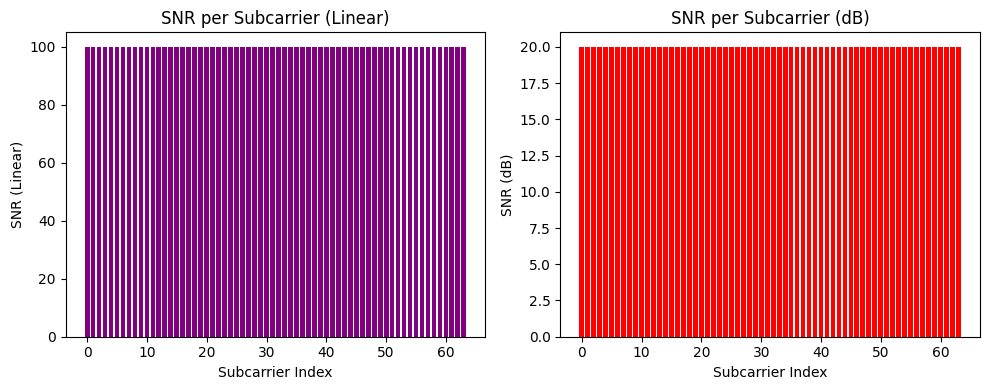

In [560]:
noise_spectral_power_density = simulation_results["noise_power_watts"] / (params.number_of_subcarriers * params.bandwidth_hz)
simulation_results["noise_spectral_power_density"] = noise_spectral_power_density
print(f"Noise Spectral Power Density: {noise_spectral_power_density} Watts/Hz")

snr_linear_per_subcarrier = simulation_results["allocated_powers"] / noise_spectral_power_density
snr_db_per_subcarrier = 10 * np.log10(snr_linear_per_subcarrier + 1e-12)  # Adding a small value to avoid log(0)
simulation_results["snr_linear_per_subcarrier"] = snr_linear_per_subcarrier
simulation_results["snr_db_per_subcarrier"] = snr_db_per_subcarrier

plot_vectors_as_bar_chart(
    vectors=[
        simulation_results["snr_linear_per_subcarrier"],
        simulation_results["snr_db_per_subcarrier"]
    ],
    titles=[
        "SNR per Subcarrier (Linear)",
        "SNR per Subcarrier (dB)"
    ],
    xlabels=[
        "Subcarrier Index",
        "Subcarrier Index"
    ],
    ylabels=[
        "SNR (Linear)",
        "SNR (dB)"
    ],
    colors=[
        "purple",
        "red"
    ]
)

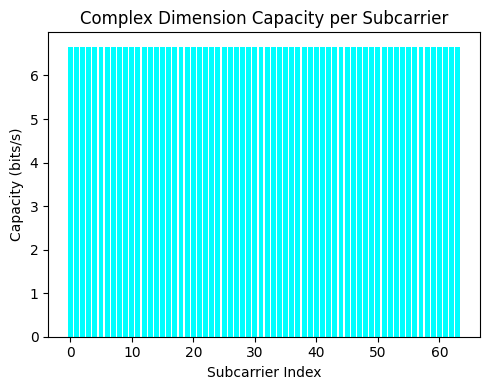

In [561]:
complex_dimension_capacity = params.bandwidth_hz * np.log2(1 + snr_linear_per_subcarrier)
simulation_results["complex_dimension_capacity"] = complex_dimension_capacity

plot_vectors_as_bar_chart(
    vectors=[
        simulation_results["complex_dimension_capacity"],
    ],
    titles=[
        "Complex Dimension Capacity per Subcarrier",
    ],
    xlabels=[
        "Subcarrier Index",
    ],
    ylabels=[
        "Capacity (bits/s)",
    ],
    colors=[
        "cyan",
    ]
)

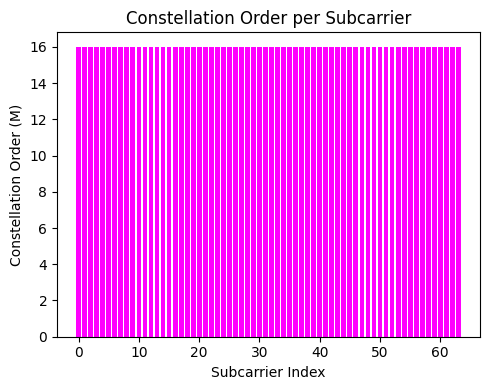

In [562]:
bits_per_symbol_per_subcarrier = simulation_results["complex_dimension_capacity"] / params.bandwidth_hz
simulation_results["bits_per_symbol_per_subcarrier"] = bits_per_symbol_per_subcarrier

constellation_orders_per_subcarrier = np.array(
    [
        params.constellation_type.calculate_bit_loading_order(
            ser=params.ser_target,
            snr=snr_linear
        ) for snr_linear in simulation_results["snr_linear_per_subcarrier"]
    ]
)

simulation_results["constellation_orders_per_subcarrier"] = constellation_orders_per_subcarrier

plot_vectors_as_bar_chart(
    vectors=[
        simulation_results["constellation_orders_per_subcarrier"],
    ],
    titles=[
        "Constellation Order per Subcarrier",
    ],
    xlabels=[
        "Subcarrier Index",
    ],
    ylabels=[
        "Constellation Order (M)",
    ],
    colors=[
        "magenta",
    ]
)

In [563]:
"""Transmit using OFDM workflow"""

from ofdm_based_systems.bits_generation.models import AdaptiveBitsGenerator, NDArray, RandomBitsGenerator
from ofdm_based_systems.equalization.models import NoEqualizator
from ofdm_based_systems.modulation.models import OFDMModulator
from ofdm_based_systems.prefix.models import CyclicPrefixScheme
from ofdm_based_systems.serial_parallel.models import SerialToParallelConverter
from ofdm_based_systems.constellation.adaptive import AdaptiveConstellationMapper

prefix_length = channel.order

bits_generator: AdaptiveBitsGenerator = AdaptiveBitsGenerator(
    bits_per_subcarrier=simulation_results["bits_per_symbol_per_subcarrier"],
    num_ofdm_symbols=params.number_of_symbols
)
total_bits = bits_generator.get_total_bits()
print(f"Total data to be transmitted: {total_bits} bits")

serial_parallel_converter: SerialToParallelConverter = SerialToParallelConverter()
constellation_mapper: IConstellationMapper = AdaptiveConstellationMapper(
    constellation_orders=simulation_results["constellation_orders_per_subcarrier"],
    base_mapper_class=params.constellation_type,
    num_subcarriers=params.number_of_subcarriers
)
ofdm_modulator: OFDMModulator = OFDMModulator(
    num_subcarriers=params.number_of_subcarriers,
    prefix_scheme=CyclicPrefixScheme(prefix_length=prefix_length),
    equalizator=NoEqualizator(
        channel_frequency_response=simulation_results["channel_frequency_response"],
        snr_db=params.snr_dB
    )
)

# ===========

bits = bits_generator.generate_bits(total_bits)
transmitted_bits = read_bits_from_stream(stream=bits)
simulation_results["transmitted_bits"] = transmitted_bits

symbols: NDArray[np.complex128] = constellation_mapper.encode(bits)
print(f"symbols shape = {symbols.shape}")
mean_power = np.mean(np.abs(symbols) ** 2)
print(f"Mean power of symbols before scaling: {mean_power:.3f} W")
simulation_results["transmitted_symbols"] = symbols

Total data to be transmitted: 3840000 bits
symbols shape = (960000,)
Mean power of symbols before scaling: 0.999 W


In [564]:

parallel_symbols = serial_parallel_converter.to_parallel(symbols, params.number_of_subcarriers)
print(f"parallel_symbols shape = {parallel_symbols.shape}")

# apply power allocation (scaling)
parallel_symbols = parallel_symbols * np.sqrt(simulation_results["allocated_powers"])[np.newaxis, :]
print(f"scaled parallel_symbols shape = {parallel_symbols.shape}")
total_power_after_scaling = np.mean(np.abs(parallel_symbols) ** 2) * params.number_of_subcarriers
print(f"Total power of symbols after scaling: {total_power_after_scaling:.3f} W")

if not np.isclose(total_power_after_scaling, params.total_power_watts, rtol=1e-3):
    print_warning_message(
        f"Total power of symbols after scaling ({total_power_after_scaling:.3f} W) does not match total power available ({params.total_power_watts} W)."
    )

ofdm_symbols = ofdm_modulator.modulate(parallel_symbols)
print(f"OFDM symbols shape = {ofdm_symbols.shape}")
total_power_of_ofdm_symbols = np.mean(np.abs(ofdm_symbols) ** 2) * params.number_of_subcarriers
print(f"Total power of OFDM symbols: {total_power_of_ofdm_symbols:.3f} W")

if not np.isclose(total_power_of_ofdm_symbols, params.total_power_watts, rtol=1e-3):
    print_warning_message(
        f"Total power of OFDM symbols ({total_power_of_ofdm_symbols:.3f} W) does not match total power available ({params.total_power_watts} W)."
    )


parallel_symbols shape = (15000, 64)
scaled parallel_symbols shape = (15000, 64)
Total power of symbols after scaling: 0.999 W
🚨 Warning: Total power of symbols after scaling (0.999 W) does not match total power available (1.0 W).
OFDM symbols shape = (15000, 64)
Total power of OFDM symbols: 0.999 W
🚨 Warning: Total power of OFDM symbols (0.999 W) does not match total power available (1.0 W).


In [565]:
power_signal = np.abs(ofdm_symbols) ** 2
peak_power = np.max(power_signal)
avg_power = np.mean(power_signal)
papr_linear = peak_power / avg_power
papr_db = 10 * np.log10(papr_linear + 1e-12)  # Adding a small value to avoid log(0)
print(f"PAPR (Linear): {papr_linear:.3f}")
print(f"PAPR (dB): {papr_db:.3f} dB")
simulation_results["papr_linear"] = papr_linear
simulation_results["papr_db"] = papr_db

PAPR (Linear): 13.151
PAPR (dB): 11.190 dB


In [566]:
serial_ofdm_symbols = serial_parallel_converter.to_serial(ofdm_symbols)
print(f"Serial OFDM symbols shape = {serial_ofdm_symbols.shape}")
received_ofdm_symbols = channel.transmit(serial_ofdm_symbols)
print(f"Received OFDM symbols shape = {received_ofdm_symbols.shape}")
received_total_power = np.mean(np.abs(received_ofdm_symbols) ** 2) * params.number_of_subcarriers
print(f"Total power of received OFDM symbols: {received_total_power:.3f} W")

Serial OFDM symbols shape = (960000,)
Received OFDM symbols shape = (960000,)
Total power of received OFDM symbols: 64.638 W


In [567]:
from typing import BinaryIO


received_parallel_ofdm_symbols = serial_parallel_converter.to_parallel(received_ofdm_symbols, params.number_of_subcarriers + prefix_length)
print(f"Received parallel OFDM symbols shape = {received_parallel_ofdm_symbols.shape}")

demodulated_symbols = ofdm_modulator.demodulate(received_parallel_ofdm_symbols)
print(f"Demodulated symbols shape = {demodulated_symbols.shape}")
total_power_of_demodulated_symbols = np.mean(np.abs(demodulated_symbols) ** 2) * params.number_of_subcarriers
print(f"Total power of demodulated symbols: {total_power_of_demodulated_symbols:.3f} W")

# Normalize demodulated symbols to unity power before decoding
mean_power_demodulated = np.mean(np.abs(demodulated_symbols) ** 2)
demodulated_symbols = demodulated_symbols / np.sqrt(mean_power_demodulated)
print(f"Mean power of demodulated symbols after normalization: {np.mean(np.abs(demodulated_symbols) ** 2):.3f} W")


demodulated_serial_symbols = serial_parallel_converter.to_serial(demodulated_symbols)
print(f"Demodulated serial symbols shape = {demodulated_serial_symbols.shape}")
simulation_results["received_symbols"] = demodulated_serial_symbols

received_bits = constellation_mapper.decode(demodulated_serial_symbols)

Received parallel OFDM symbols shape = (15000, 64)
Demodulated symbols shape = (15000, 64)
Total power of demodulated symbols: 64.638 W
Mean power of demodulated symbols after normalization: 1.000 W
Demodulated serial symbols shape = (960000,)


In [568]:


received_bits_list = read_bits_from_stream(stream=received_bits)
print(f"Received bits length = {len(received_bits_list)}")

if len(received_bits_list) != len(simulation_results["transmitted_bits"]):
    print_error_message(
        f"Number of received bits ({len(received_bits_list)}) does not match number of transmitted bits ({len(simulation_results['transmitted_bits'])})."
    )
simulation_results["received_bits"] = received_bits_list

Received bits length = 3840000


In [569]:
# To verify the correctness of the received symbols, we can re-encode the received bits
recoded_symbols = constellation_mapper.encode(received_bits)
print(f"Recoded symbols shape = {recoded_symbols.shape}")

# apply power allocation (scaling) to recoded symbols
# recoded_parallel_symbols = serial_parallel_converter.to_parallel(recoded_symbols, params.number_of_subcarriers)
# scaled_recoded_parallel_symbols = recoded_parallel_symbols * np.sqrt(simulation_results["allocated_powers"])[np.newaxis, :]
# normalized_recoded_symbols = serial_parallel_converter.to_serial(scaled_recoded_parallel_symbols)

simulation_results["recoded_symbols"] = recoded_symbols

Recoded symbols shape = (960000,)


In [574]:
bit_error_rate = np.sum(
    np.array(simulation_results["transmitted_bits"]) != np.array(simulation_results["received_bits"])
) / len(simulation_results["transmitted_bits"])
print(f"Bit Error Rate (BER): {bit_error_rate:.6f}")
simulation_results["bit_error_rate"] = bit_error_rate

print(f"{simulation_results['transmitted_symbols']}")
print(f"{recoded_symbols}")

symbol_error_rate = np.sum(
    np.isclose(simulation_results['transmitted_symbols'], recoded_symbols) == False
) / len(simulation_results['transmitted_symbols'])
print(f"Symbol Error Rate (SER): {symbol_error_rate:.6f}")
simulation_results["symbol_error_rate"] = symbol_error_rate

Bit Error Rate (BER): 0.000002
[ 0.9486833 -0.31622777j -0.9486833 +0.9486833j  -0.9486833 +0.31622777j
 ... -0.31622777-0.9486833j   0.31622777+0.9486833j
  0.31622777+0.31622777j]
[ 0.9486833 -0.31622777j -0.9486833 +0.9486833j  -0.9486833 +0.31622777j
 ... -0.31622777-0.9486833j   0.31622777+0.9486833j
  0.31622777+0.31622777j]
Symbol Error Rate (SER): 0.000008


In [ ]:
from ofdm_based_systems.utils.visualization import plot_adaptive_constellation_diagram


plot_adaptive_constellation_diagram(
    received_symbols=simulation_results["received_symbols"],
    constellation_orders=simulation_results["constellation_orders_per_subcarrier"],
    constellation_title=CONSTELLATION_TYPE.value,
    num_subcarriers=params.number_of_subcarriers,
    ber=simulation_results["bit_error_rate"],
    ser=simulation_results["symbol_error_rate"],
    snr_db=params.snr_dB,
    papr_db=simulation_results["papr_db"],
)


- Noise Power ($I$):
$$
SNR = \frac{P}{I}
$$
$$
I = \frac{P}{SNR}
$$
$$
I_0 = \frac{I}{BW}
$$

- Energy per Bit:
$$
E_b = \frac{P}{R}
$$

- Energy per Symbol:
$$
E_s = E_b \cdot \log_2(M)
$$

- SNR per subchannel (linear):
$$
\gamma = \frac{P_0}{I_0}
$$

- Amount of bits per symbol:

$$
R = \frac{1}{2}\left(log_2(1 + \frac{\gamma}{\Gamma})\right)
$$